In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade tensorflow
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompat

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from PIL import Image
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix,precision_score,roc_curve,auc,recall_score,precision_score

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.layers import AveragePooling2D,MaxPooling2D

In [ ]:
WORK_DIR = '/content/drive/MyDrive/Cervical_Dataset_Main'

CLASSES = [ 'Dyskeratotic','Koilocytotic','Metaplastic','Parabasal','Superficial-Intermediat' ]

IMG=224
# As i found my image size is 227*227.
IMAGE_SIZE = [224, 224]
DIM = (IMG,IMG )

model_acc={}
model_val_acc={}

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from PIL import Image
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix,precision_score,roc_curve,auc,recall_score,precision_score

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG # Use tf.keras for ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.layers import AveragePooling2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Use tf.keras for ImageDataGenerator

In [ ]:
import tensorflow as tf

# Use tf.keras.preprocessing.image.ImageDataGenerator instead of keras.preprocessing.image.ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your parameters
ZOOM = [0.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

# Create the ImageDataGenerator
work_dr = ImageDataGenerator(rescale=1./255,
                             brightness_range=BRIGHT_RANGE,
                             zoom_range=ZOOM,
                             data_format=DATA_FORMAT,
                             fill_mode=FILL_MODE,
                             horizontal_flip=HORZ_FLIP)

# Use the ImageDataGenerator
train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR,
                                             target_size=DIM,
                                             batch_size=6320,
                                             shuffle=False)

Found 962 images belonging to 4 classes.


In [ ]:
from random import randint

# get image lables
labels = dict(zip([0, 1], CLASSES))
# get a batch of images
# Use next(train_data_gen) instead of train_data_gen.next()
train_data, train_labels = next(train_data_gen)

In [ ]:
# This code is used to conformn that the above code do his work perfectly.
print(train_data.shape, train_labels.shape)

(962, 224, 224, 3) (962, 4)


In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)


In [ ]:
print(train_data.shape)

(769, 224, 224, 3)


# ***D-CNN Mobilenet v2 ***

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D, Input
import seaborn as sns

# Assuming 'train_data', 'train_labels', 'test_data', 'test_labels' are defined

# Load the pre-trained MobileNetV2 model without the top fully connected layer
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(224, 224, 3)),
    pooling=None  # We'll add our own pooling later
)

# Freeze the base model layers to retain the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Define the D-CNN model architecture
def mobilenetv2_dcnn_model():
    model = Sequential()
    model.add(base_model)

    # Custom Convolutional Layer 1
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Custom Convolutional Layer 2
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Custom Convolutional Layer 3 - Modified for MobileNetV2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    # Removed the MaxPooling2D layer here to prevent negative dimension size
    model.add(BatchNormalization())

    # Global Average Pooling to reduce dimensionality
    model.add(GlobalAveragePooling2D())

    # Fully connected layers for classification
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))  # Adjust for your number of classes

    return model

# Create the model
model_9 = mobilenetv2_dcnn_model()

# Compile the model
model_9.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Summary of the model to verify the architecture
model_9.summary()

<ipython-input-11-9031194c84a3>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 512)           │       5,898,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 3, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 1, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,709,700 (37.04 MB)

 Trainable params: 7,449,924 (28.42 MB)

 Non-trainable params: 2,259,776 (8.62 MB)

In [ ]:
EPOCHS = 10
history9 = model_9.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 627ms/step - accuracy: 0.5847 - loss: 0.9822 - val_accuracy: 0.7461 - val_loss: 1.4659
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.8366 - loss: 0.4702 - val_accuracy: 0.7927 - val_loss: 1.1819
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8622 - loss: 0.3748 - val_accuracy: 0.8238 - val_loss: 0.8071
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8874 - loss: 0.2980 - val_accuracy: 0.7409 - val_loss: 0.7440
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9457 - loss: 0.1798 - val_accuracy: 0.8860 - val_loss: 0.2989
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9574 - loss: 0.1353 - val_accuracy: 0.9067 - val_loss: 0.5601
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9609 - loss: 0.1045 - val_accuracy: 0.8912 - val_loss: 0.5400
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9622 - loss: 0.1395 - val_accuracy: 0.9171 - val_loss:

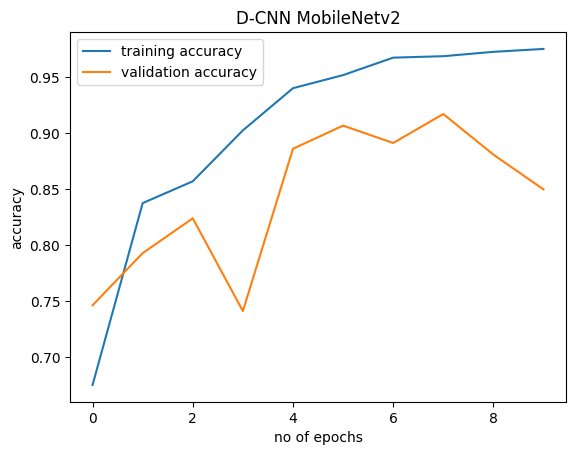

In [ ]:
acc=history9.history['accuracy']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history9.history['val_accuracy']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("D-CNN MobileNetv2")
plt.legend()

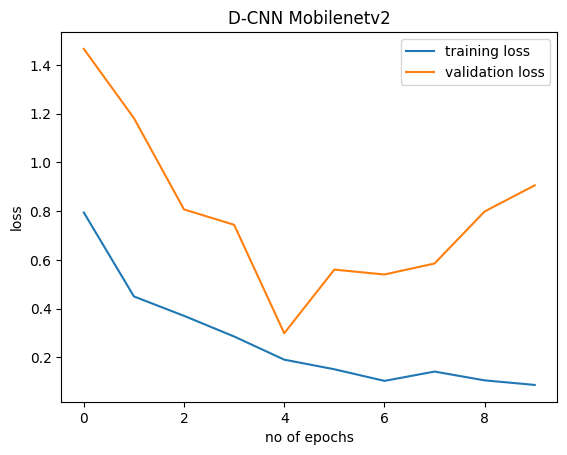

In [ ]:
acc=history9.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history9.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title("D-CNN Mobilenetv2")
plt.legend()

In [ ]:
Train_acc9=history9.history['accuracy'][-1]
Val_acc9=history9.history['val_accuracy'][-1]

model_acc["D-CNN Mobilenetv2"]=Train_acc9
model_val_acc["D-CNN Mobilenetv2"]=Val_acc9

print("Train accuracy",Train_acc9)
print("Validation accuracy",Val_acc9)

Train accuracy 0.9752925634384155
Validation accuracy 0.8497409224510193


In [ ]:
print("[INFO] evaluating network...")
predIdxs9 = model_9.predict(test_data, batch_size=32)
predIdxs9 = np.argmax(predIdxs9, axis=1)
print(classification_report(test_labels.argmax(axis=1), predIdxs9))

[INFO] evaluating network...
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 553ms/step
              precision    recall  f1-score   support

           0       0.83      0.54      0.65        28
           1       0.94      0.71      0.81        21
           2       0.98      0.94      0.96       127
           3       0.41      0.88      0.56        17

    accuracy                           0.85       193
   macro avg       0.79      0.77      0.74       193
weighted avg       0.90      0.85      0.86       193



In [ ]:
cf9=confusion_matrix(test_labels.argmax(axis=1), predIdxs9)
cf9

array([[ 15,   1,   3,   9],
       [  0,  15,   0,   6],
       [  1,   0, 119,   7],
       [  2,   0,   0,  15]])

<Axes: >

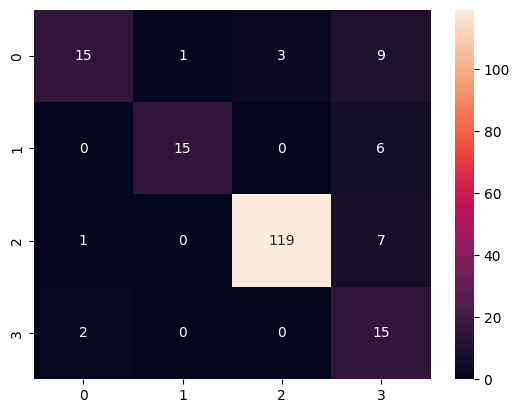

In [ ]:
import seaborn as sns
sns.heatmap(cf9, annot=True,fmt="1.0f")

# **D-CNN Resnet50**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D, Input

# Load the pre-trained ResNet50 model without the top fully connected layer
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(224, 224, 3)),
    pooling=None
)

# Freeze the base model layers to retain the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Define the D-CNN model architecture
def resnet50_dcnn_model():
    model = Sequential()
    model.add(base_model)

    # Custom Convolutional Layer 1
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Custom Convolutional Layer 2
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Custom Convolutional Layer 3 - Modified to reduce dimensions gradually
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    # Removed MaxPooling2D layer to prevent negative dimension size
    model.add(BatchNormalization())

    # Global Average Pooling to reduce dimensionality
    model.add(GlobalAveragePooling2D())

    # Fully connected layers for classification
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))  # Adjust the number of units for your classes

    return model

# Create the model
model_8 = resnet50_dcnn_model()

# Compile the model
model_8.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Summary of the model to verify the architecture
model_8.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 512)           │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 3, 3, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 1, 1, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1, 1, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,578,372 (131.91 MB)

 Trainable params: 10,988,868 (41.92 MB)

 Non-trainable params: 23,589,504 (89.99 MB)

In [ ]:
EPOCHS = 10
history8 = model_8.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_307']. Received: the structure of inputs=*
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 741ms/step - accuracy: 0.4308 - loss: 1.3503 - val_accuracy: 0.6580 - val_loss: 5.5199
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.6454 - loss: 0.9301 - val_accuracy: 0.6580 - val_loss: 2.4172
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.6045 - loss: 0.8636 - val_accuracy: 0.6580 - val_loss: 3.4909
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.7545 - loss: 0.6840 - val_accuracy: 0.6632 - val_loss: 1.2790
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.7523 - loss: 0.6325 - val_accuracy: 0.2176 - val_loss: 2.1773
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.7426 - loss: 0.6799 - val_accuracy: 0.4456 - val_loss: 1.2851
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.7521 - loss: 0.5826 - val_accuracy: 0.2591 - val_loss: 2.1162
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7524 - loss: 0.5822 - val_accuracy: 0.1813 - va

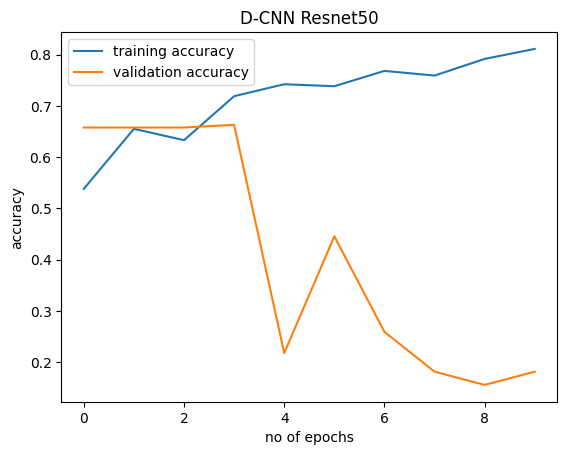

In [ ]:
acc=history8.history['accuracy']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history8.history['val_accuracy']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("D-CNN Resnet50")
plt.legend()

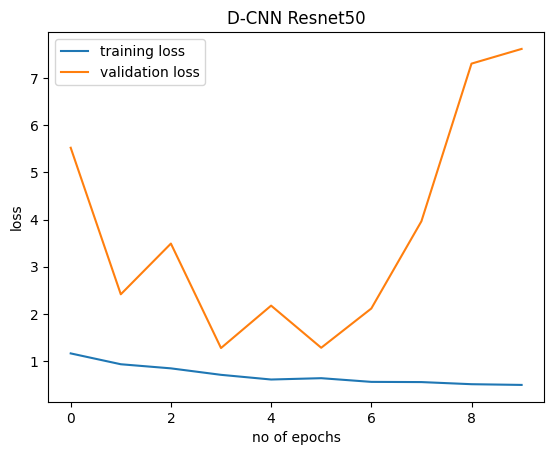

In [ ]:
acc=history8.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history8.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title("D-CNN Resnet50")
plt.legend()

In [ ]:
Train_acc8=history8.history['accuracy'][-1]
Val_acc8=history8.history['val_accuracy'][-1]

model_acc["D-CNN Resnet50"]=Train_acc8
model_val_acc["D-CNN Resnet50"]=Val_acc8

print("Train accuracy",Train_acc8)
print("Validation accuracy",Val_acc8)

Train accuracy 0.8114434480667114
Validation accuracy 0.18134714663028717


In [ ]:
print("[INFO] evaluating network...")
predIdxs8 = model_8.predict(test_data, batch_size=32)
predIdxs8 = np.argmax(predIdxs8, axis=1)
print(classification_report(test_labels.argmax(axis=1), predIdxs8))

[INFO] evaluating network...
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 679ms/step
              precision    recall  f1-score   support

           0       0.15      1.00      0.26        28
           1       0.00      0.00      0.00        21
           2       1.00      0.06      0.10       127
           3       0.00      0.00      0.00        17

    accuracy                           0.18       193
   macro avg       0.29      0.26      0.09       193
weighted avg       0.68      0.18      0.11       193



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
cf8=confusion_matrix(test_labels.argmax(axis=1), predIdxs8)
cf8

array([[ 28,   0,   0,   0],
       [ 21,   0,   0,   0],
       [120,   0,   7,   0],
       [ 17,   0,   0,   0]])

<Axes: >

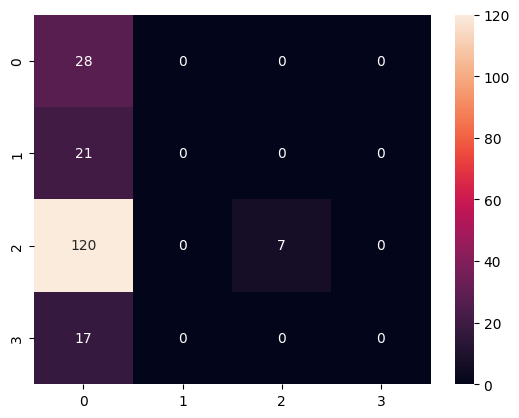

In [ ]:
import seaborn as sns
sns.heatmap(cf8, annot=True,fmt="1.0f")

# **D-CNN VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf

# Load the pre-trained VGG16 model without the top fully connected layer
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(224, 224, 3)),
    pooling=None
)

# Freeze the base model layers to retain the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Define the D-CNN model architecture
def vgg16_dcnn_model():
    model = Sequential()
    model.add(base_model)

    # Custom Convolutional Layer 1
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Custom Convolutional Layer 2
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Custom Convolutional Layer 3 - Removed to prevent further downsampling
    # model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(BatchNormalization())

    # Global Average Pooling to reduce dimensionality
    model.add(GlobalAveragePooling2D())

    # Fully connected layers for classification
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))  # Adjust the number of units for your classes

    return model

# Create the model
model_7 = vgg16_dcnn_model()

# Compile the model
model_7.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Summary of the model to verify the architecture
model_7.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,364,676 (70.06 MB)

 Trainable params: 3,648,452 (13.92 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [ ]:
EPOCHS = 10
history7 = model_7.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_635']. Received: the structure of inputs=*
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 582ms/step - accuracy: 0.6308 - loss: 0.9685 - val_accuracy: 0.6580 - val_loss: 3.8209
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.7983 - loss: 0.5390 - val_accuracy: 0.6839 - val_loss: 1.9776
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.8441 - loss: 0.4196 - val_accuracy: 0.6580 - val_loss: 2.3598
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.8938 - loss: 0.2719 - val_accuracy: 0.7461 - val_loss: 1.1311
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9203 - loss: 0.1822 - val_accuracy: 0.6788 - val_loss: 2.7978
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.9160 - loss: 0.2179 - val_accuracy: 0.8497 - val_loss: 0.5500
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.9242 - loss: 0.1816 - val_accuracy: 0.8964 - val_loss: 0.4887
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.9685 - loss: 0.1303 - val_accuracy: 0.8031 - 

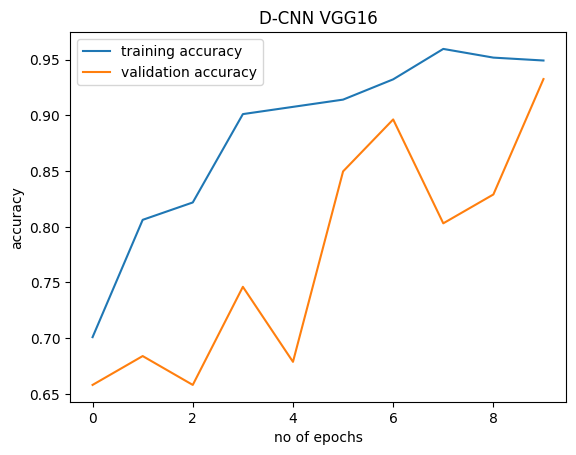

In [ ]:
acc=history7.history['accuracy']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history7.history['val_accuracy']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("D-CNN VGG16")
plt.legend()

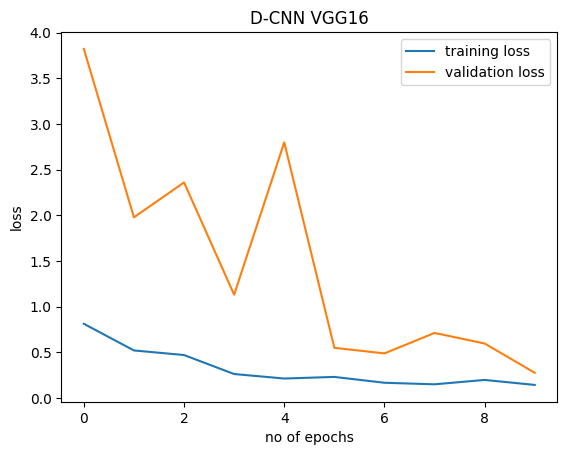

In [ ]:
acc=history7.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history7.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title("D-CNN VGG16")
plt.legend()

In [ ]:
Train_acc7=history7.history['accuracy'][-1]
Val_acc7=history7.history['val_accuracy'][-1]

model_acc["D-CNN VGG16"]=Train_acc7
model_val_acc["D-CNN VGG16"]=Val_acc7

print("Train accuracy",Train_acc7)
print("Validation accuracy",Val_acc7)

Train accuracy 0.9492847919464111
Validation accuracy 0.9326424598693848


In [ ]:
print("[INFO] evaluating network...")
predIdxs7 = model_7.predict(test_data, batch_size=32)
predIdxs7 = np.argmax(predIdxs7, axis=1)
print(classification_report(test_labels.argmax(axis=1), predIdxs7))

[INFO] evaluating network...


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       0.77      0.95      0.85        21
           2       0.97      0.98      0.98       127
           3       0.94      0.88      0.91        17

    accuracy                           0.93       193
   macro avg       0.90      0.88      0.88       193
weighted avg       0.94      0.93      0.93       193



In [ ]:
cf7=confusion_matrix(test_labels.argmax(axis=1), predIdxs7)
cf7

array([[ 20,   3,   4,   1],
       [  1,  20,   0,   0],
       [  0,   2, 125,   0],
       [  1,   1,   0,  15]])

<Axes: >

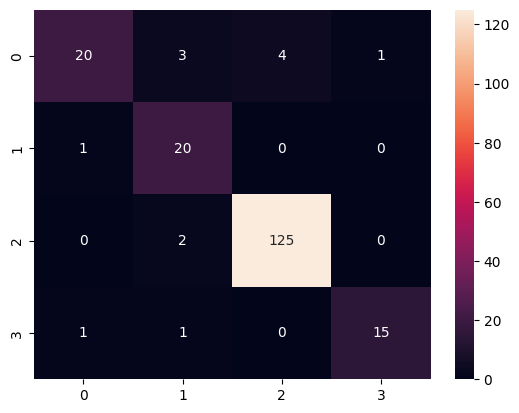

In [ ]:
import seaborn as sns
sns.heatmap(cf7, annot=True,fmt="1.0f")

# **Deep CNN DenseNet 201**

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf

# Load the pre-trained DenseNet201 model without the top fully connected layer
base_model = DenseNet201(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(224, 224, 3)),
    pooling=None
)

# Freeze the base model layers to retain the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Define the D-CNN model architecture
def densenet_dcnn_model():
    model = Sequential()
    model.add(base_model)

    # Custom Convolutional Layer 1
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Custom Convolutional Layer 2
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Custom Convolutional Layer 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    # Changed MaxPooling2D to have padding='same' and pool_size=(1, 1)
    model.add(MaxPooling2D(pool_size=(1, 1), padding='same'))
    model.add(BatchNormalization())

    # Global Average Pooling to reduce dimensionality
    model.add(GlobalAveragePooling2D())

    # Fully connected layers for classification
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    return model

# Create the model
model_6 = densenet_dcnn_model()

# Compile the model
model_6.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Summary of the model to verify the architecture
model_6.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 7, 7, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 512)           │       8,847,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 3, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 3, 3, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 1, 1, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 1, 1, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,722,820 (109.57 MB)

 Trainable params: 10,399,044 (39.67 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

In [ ]:
EPOCHS = 10
history6 = model_6.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_774']. Received: the structure of inputs=*
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.5603 - loss: 1.0918 - val_accuracy: 0.6580 - val_loss: 3.0073
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 187ms/step - accuracy: 0.8087 - loss: 0.5198 - val_accuracy: 0.6788 - val_loss: 1.4300
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.8464 - loss: 0.3544 - val_accuracy: 0.7668 - val_loss: 0.8928
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.9240 - loss: 0.1949 - val_accuracy: 0.8756 - val_loss: 0.4970
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.9287 - loss: 0.2158 - val_accuracy: 0.8394 - val_loss: 0.5876
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.9234 - loss: 0.2268 - val_accuracy: 0.8912 - val_loss: 0.4120
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.9716 - loss: 0.0938 - val_accuracy: 0.9067 - val_loss: 0.3753
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.9734 - loss: 0.0882 - val_accuracy: 0.8912 - val_

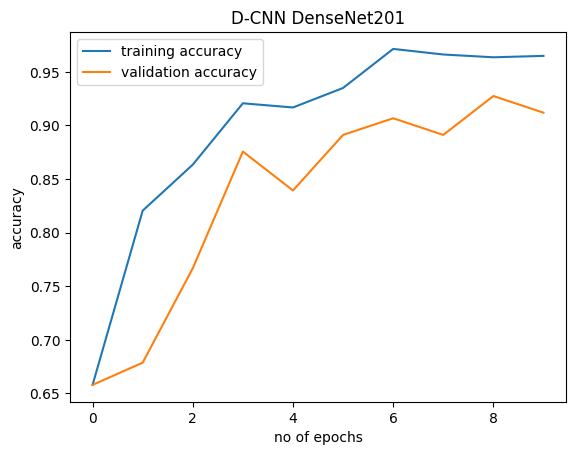

In [ ]:
acc=history6.history['accuracy']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history6.history['val_accuracy']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("D-CNN DenseNet201")
plt.legend()

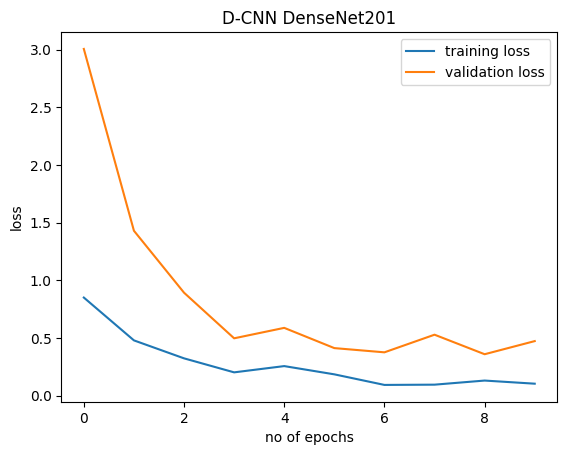

In [ ]:
acc=history6.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history6.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title("D-CNN DenseNet201")
plt.legend()

In [ ]:
Train_acc6=history6.history['accuracy'][-1]
Val_acc6=history6.history['val_accuracy'][-1]

model_acc["D-CNN DenseNet201"]=Train_acc6
model_val_acc["D-CNN DenseNet201"]=Val_acc6

print("Train accuracy",Train_acc6)
print("Validation accuracy",Val_acc6)

Train accuracy 0.9648894667625427
Validation accuracy 0.9119170904159546


In [ ]:
print("[INFO] evaluating network...")
predIdxs6 = model_6.predict(test_data, batch_size=32)
predIdxs6 = np.argmax(predIdxs6, axis=1)
print(classification_report(test_labels.argmax(axis=1), predIdxs6))

[INFO] evaluating network...


7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        28
           1       0.90      0.90      0.90        21
           2       0.96      1.00      0.98       127
           3       0.91      0.59      0.71        17

    accuracy                           0.91       193
   macro avg       0.87      0.80      0.83       193
weighted avg       0.91      0.91      0.91       193



In [ ]:
cf6=confusion_matrix(test_labels.argmax(axis=1), predIdxs6)
cf6

array([[ 20,   2,   5,   1],
       [  2,  19,   0,   0],
       [  0,   0, 127,   0],
       [  7,   0,   0,  10]])

<Axes: >

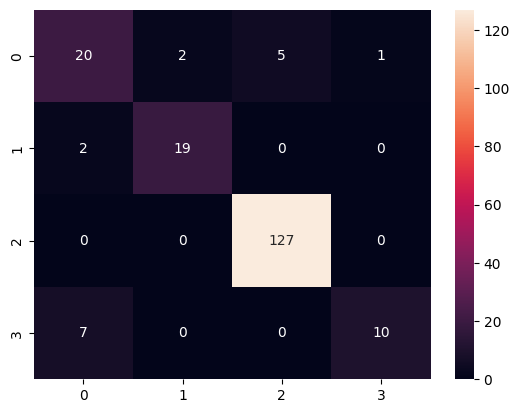

In [ ]:
import seaborn as sns
sns.heatmap(cf6, annot=True,fmt="1.0f")

# **D-CNN Inception-V3**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D, Input
import seaborn as sns

# Load the pre-trained InceptionV3 model without the top fully connected layer
base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(224, 224, 3)),
    pooling=None
)

# Freeze the base model layers to retain the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Define the D-CNN model architecture
def inceptionv3_dcnn_model():
    model = Sequential()
    model.add(base_model)

    # Custom Convolutional Layer 1
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Custom Convolutional Layer 2
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # Custom Convolutional Layer 3 - Adjusted to avoid negative dimension size
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    # Replacing MaxPooling2D with GlobalAveragePooling2D to handle smaller feature maps
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())

    # Fully connected layers for classification
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))  # Adjust the number of units for your classes

    return model

# Create the model
model_11 = inceptionv3_dcnn_model()

# Compile the model
model_11.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# Summary of the model to verify the architecture
model_11.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_105 (Conv2D)                  │ (None, 5, 5, 512)           │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_105              │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_106 (Conv2D)                  │ (None, 2, 2, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_106              │ (None, 1, 1, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_107 (Conv2D)                  │ (None, 1, 1, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_107              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,793,444 (125.10 MB)

 Trainable params: 10,988,868 (41.92 MB)

 Non-trainable params: 21,804,576 (83.18 MB)

In [ ]:
EPOCHS = 10
history11 = model_11.fit(train_data, train_labels, validation_data=(test_data, test_labels),batch_size=32, epochs=EPOCHS)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1652']. Received: the structure of inputs=*
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 989ms/step - accuracy: 0.4726 - loss: 1.3464 - val_accuracy: 0.6788 - val_loss: 1.7323
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.7653 - loss: 0.5959 - val_accuracy: 0.7098 - val_loss: 0.6612
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8372 - loss: 0.3849 - val_accuracy: 0.7461 - val_loss: 0.6939
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8955 - loss: 0.3368 - val_accuracy: 0.7979 - val_loss: 0.6032
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9113 - loss: 0.2297 - val_accuracy: 0.8705 - val_loss: 0.3964
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9427 - loss: 0.1659 - val_accuracy: 0.8497 - val_loss: 0.7141
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9582 - loss: 0.1388 - val_accuracy: 0.8342 - val_loss: 0.6623
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9549 - loss: 0.1774 - val_accuracy: 0.8238 - val

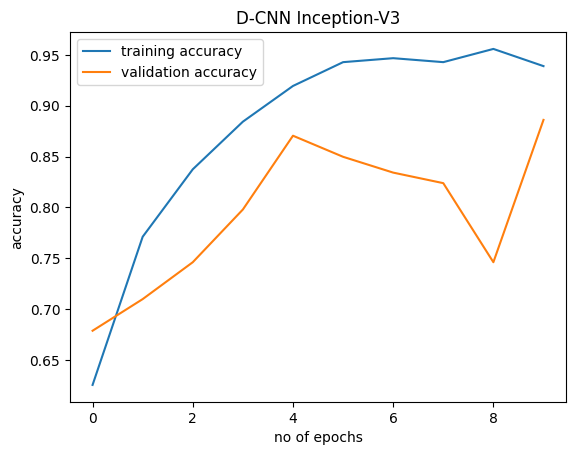

In [ ]:
acc=history11.history['accuracy']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history11.history['val_accuracy']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title("D-CNN Inception-V3")
plt.legend()

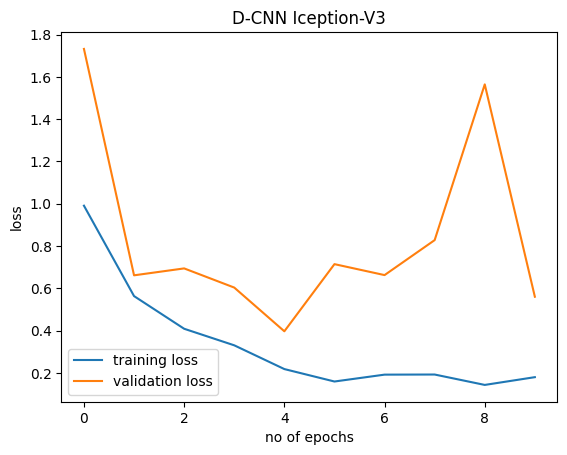

In [ ]:
acc=history11.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,EPOCHS)
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history11.history['val_loss']  ##getting validation accuracy of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title("D-CNN Iception-V3")
plt.legend()

In [ ]:
print("[INFO] evaluating network...")
predIdxs11 = model_11.predict(test_data, batch_size=32)
predIdxs11 = np.argmax(predIdxs11, axis=1)
print(classification_report(test_labels.argmax(axis=1), predIdxs11))

[INFO] evaluating network...
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        28
           1       0.88      0.67      0.76        21
           2       0.98      0.97      0.97       127
           3       0.61      0.82      0.70        17

    accuracy                           0.89       193
   macro avg       0.79      0.79      0.79       193
weighted avg       0.89      0.89      0.89       193



In [ ]:
cf11=confusion_matrix(test_labels.argmax(axis=1), predIdxs11)
cf11

array([[ 20,   1,   1,   6],
       [  3,  14,   2,   2],
       [  2,   1, 123,   1],
       [  3,   0,   0,  14]])

<Axes: >

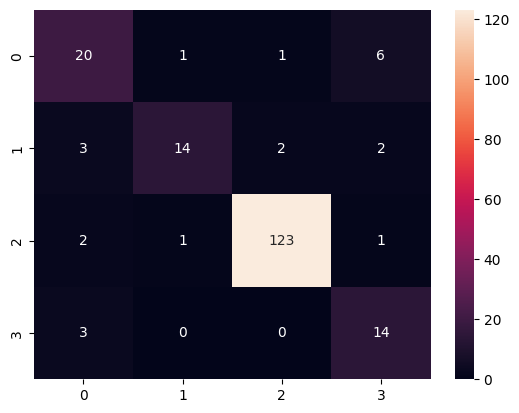

In [ ]:
import seaborn as sns
sns.heatmap(cf11, annot=True,fmt="1.0f")

# **Model Evaluations**

In [ ]:
model_scores = pd.DataFrame(model_acc, index=['Score']).transpose()
model_scores = model_scores.sort_values('Score',ascending=False)
model_scores

,Score
D-CNN Mobilenetv2,0.975293
D-CNN DenseNet201,0.964889
D-CNN VGG16,0.949285
D-CNN Resnet50,0.811443


In [ ]:
model_scores = model_scores.reset_index().rename({"index":"Algorithms"}, axis = 1)

model_scores.style.bar()

,Algorithms,Score
0,D-CNN Mobilenetv2,0.975293
1,D-CNN DenseNet201,0.964889
2,D-CNN VGG16,0.949285
3,D-CNN Resnet50,0.811443


Text(0, 0.5, 'Score')

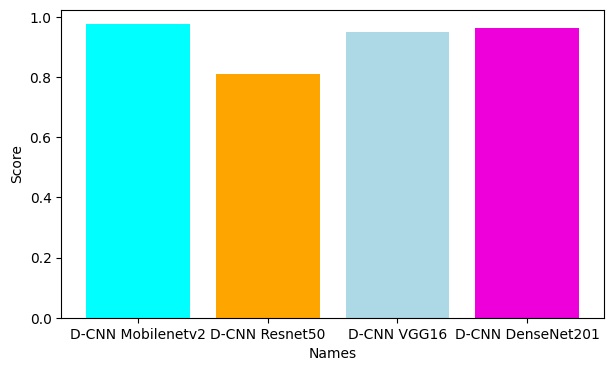

In [ ]:
namess = list(model_acc.keys())
valuess = list(model_acc.values())
colors=["#00FFFF","#FFA500","#ADD8E6","#ED00D9","#ED1400"]
textprops = {"fontsize":22}

plt.figure(figsize=(7,4))
plt.bar(namess,valuess,color=colors)
plt.xlabel("Names")
plt.ylabel("Score")

In [ ]:
model_scoress = pd.DataFrame(model_val_acc, index=['Score']).transpose()
model_scores_val = model_scoress.sort_values('Score',ascending=False)

In [ ]:
model_scores_val

,Score
D-CNN VGG16,0.932642
D-CNN DenseNet201,0.911917
D-CNN Mobilenetv2,0.849741
D-CNN Resnet50,0.181347


In [ ]:
model_scores_val = model_scores_val.reset_index().rename({"index":"Algorithms"}, axis = 1)

model_scores_val.style.bar()

,Algorithms,Score
0,D-CNN VGG16,0.932642
1,D-CNN DenseNet201,0.911917
2,D-CNN Mobilenetv2,0.849741
3,D-CNN Resnet50,0.181347


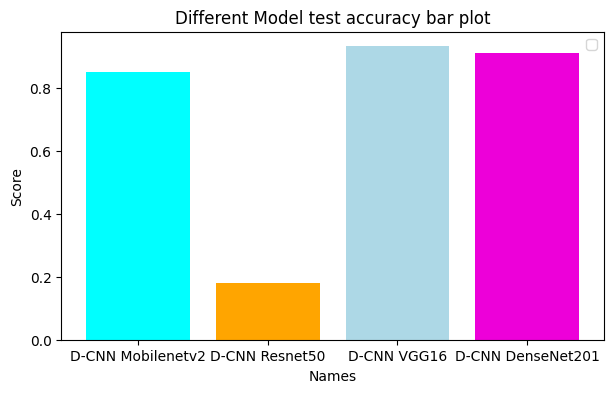

In [ ]:
names = list(model_val_acc.keys())
values = list(model_val_acc.values())
colors=["#00FFFF","#FFA500","#ADD8E6","#ED00D9","#ED1400"]
textprops = {"fontsize":22}

plt.figure(figsize=(7,4))
plt.bar(names,values,color=colors)
plt.xlabel("Names")
plt.ylabel("Score")
plt.title("Different Model test accuracy bar plot")
plt.legend()
